In [ ]:
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

import seaborn as sns
import matplotlib.pyplot as plt

import h5py
import json
from pathlib import Path

print("Importing Complete")

Importing Complete


In [ ]:
#Let's take a look at how many tickers were avaliable on yahoo finance and those that were missing
#We will also need all the SP500 changes to check if our historicals match up with the time they were in the SP500

avaliable_yf_tickers_filepath = '/p3Ainputs/avaliable_yf_tickers.json'

missing_yf_tickers_filepath = '/p3Ainputs/missing_yf_tickers.json'

sp500_changes_filepath = '/p3Ainputs/S&P500 Consitutents 20061009-20220116.json'

with open(avaliable_yf_tickers_filepath, 'r') as f:
  avaliable_yf_tickers = json.load(f)

with open(missing_yf_tickers_filepath, 'r') as f:
  missing_yf_tickers = json.load(f)

sp500_changes = pd.read_json(sp500_changes_filepath) #We saved sp500_changes with pd.to_json in part 2 so we can load with pd.read_json()

print('You have {} avaliable tickers and {} missing tickers for a total of {} tickers'.format(len(avaliable_yf_tickers),
                                                                                              len(missing_yf_tickers),
                                                                                              len(avaliable_yf_tickers+missing_yf_tickers)))

You have 672 avaliable tickers and 176 missing tickers for a total of 848 tickers


In [ ]:
#Let's also load the historicals we recently downloaded from Yahoo Finance to memory
#I am loading them from hdf5 files,  but the csv loader can be found at the end of the tutorial 2 notebook

def load_hdf5_tickers_as_pd_historicals(tickers, filepath):
  historicals = dict()
  columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
  
  for ticker in tickers:
    hdf5_filepath = f'{filepath}/{ticker}.hdf5'
    ticker_file = Path(hdf5_filepath)
    if ticker_file.is_file():
      with h5py.File(hdf5_filepath, 'r') as f:
        group = f['historicals']
        data = group['15Y'][()]
      dataset = pd.DataFrame(data=data, columns=columns)
      dataset['Date'] = pd.to_datetime(dataset['Date'], unit='s') #Change our timestamps back to datetimes
      dataset = dataset.set_index('Date')
      historicals[ticker] = dataset
    else:
      print('Error {} ticker is missing'.format(ticker))
  print('All Historicals Have Been Loaded')
  return historicals

historicals_filepath = '/p3Ainputs/historicals'
historicals = load_hdf5_tickers_as_pd_historicals(avaliable_yf_tickers, historicals_filepath)

All Historicals Have Been Loaded


In [146]:
#Now let's look at the data we have
def count_all_historicals_lengths(historicals):
  hist_len_counter = dict()
  for ticker, historical in historicals.items():
    hist_len_counter.setdefault(len(historical), 0)
    hist_len_counter[len(historical)] += 1
  return hist_len_counter

hist_len_counter = count_all_historicals_lengths(historicals)

#Give them a quick sort by most common lengths and highest lenths
most_common_lens = sorted(hist_len_counter.items(), key=lambda x:x[1], reverse=True)
highest_lens = sorted(hist_len_counter.items(), key=lambda x:x[0], reverse=True)

print('Most Common Lens:\n {}'.format(most_common_lens[:5]))
print('\nHighest Lens:\n {}'.format(highest_lens[:5]))

Most Common Lens:
 [(3777, 517), (464, 2), (1882, 2), (3677, 2), (1649, 2)]

Highest Lens:
 [(3777, 517), (3776, 1), (3754, 1), (3745, 1), (3735, 1)]


In [148]:
#From above we see that the highest lens is 3778 while the majority of the historicals (515 of them) sit at a comfortable 3777 length
#Additionally in "Highest Lens", we see that past the length of 3777, very few tickers have the same amount of missing tickers
#Meaning that 3777 is the typical length of 15 years of data and we will use this length for reference and comparison
#However, the 3778 length does stand out, let's take a look at which tickers are causing this

def look_for_target_historicals_lengths(historicals, target_len):
  target_len_tickers = [ticker
                        for ticker, historical in historicals.items()
                        if target_len == len(historical)]
  return target_len_tickers

outlier_len = 3778
outlier_len_tickers = look_for_target_historicals_lengths(historicals, outlier_len)
print(outlier_len_tickers) #We see that GS and DIA stands out. Since this is a single ticker, we will simply cut the data point later that is extra from the dataset to keep the data uniform

standard_len = 3777
standard_len_tickers = look_for_target_historicals_lengths(historicals, standard_len)
print(standard_len_tickers[:5])

['GS', 'DIA']
['A', 'AAL', 'AAP', 'AAPL', 'ABC']


In [ ]:
#Let's make sure all the date ranges at 3777 is the same
#From above we see that AAPL has all this data, let's just do a quick comparison that tickers of the same length have all the same dates

def check_for_uniformity_of_dates(historicals, 
                                  tickers_to_compare, 
                                  comparsion_ticker):
  for ticker in tickers_to_compare:
    if historicals[ticker].index.equals(historicals[comparison_ticker].index): 
      pass
    else: 
      print('{} does not have the same dates as {}'.format(ticker, comparison_ticker)) #This will print only if dates do not match with AAPL
  print('Comparison Completed')

comparison_ticker = 'AAPL'
check_for_uniformity_of_dates(historicals,
                              standard_len_tickers,
                              comparison_ticker)

Comparison Completed


In [152]:
#Since we have now confirmed that all the tickers that have the length of 3777 are at the same dates, we can now get to work on the missing dates
#Let's grab all the tickers that have missing data

tickers_with_full_data = standard_len_tickers + outlier_len_tickers 
tickers_with_missing_dates = set(historicals) - set(tickers_with_full_data)
print('Tickers with missing dates:\n {}'.format(list(tickers_with_missing_dates)))

Tickers with missing dates:
 ['HPE', 'ARNC', 'WLTW', 'DNB', 'CA', 'PM', 'DAL', 'DG', 'ROH', 'GM', 'SLR', 'FANG', 'UA', 'EQ', 'HET', 'BUD', 'DOW', 'XL', 'HOT', 'BR', 'CMX', 'NE', 'COTY', 'SEDG', 'CPRI', 'WRK', 'LW', 'NAVI', 'KSU', 'OTIS', 'MRNA', 'ETSY', 'MPC', 'ADT', 'EVHC', 'FRC', 'V', 'LLL', 'CHK', 'ADCT', 'NSM', 'SII', 'DELL', 'VNT', 'CSRA', 'LYB', 'IQV', 'CVG', 'GNRC', 'BEAM', 'SCG', 'DISCK', 'PLL', 'TDC', 'PAYC', 'CDW', 'PX', 'OGN', 'MMI', 'BHF', 'COL', 'NCLH', 'CDAY', 'HII', 'HPC', 'NXPI', 'CBOE', 'SVU', 'HCP', 'JAVA', 'ALTR', 'SYF', 'ALLE', 'NCC', 'H', 'DYN', 'FCPT', 'TWX', 'PYPL', 'TWTR', 'SE', 'SOV', 'CARR', 'KMI', 'ANDV', 'MSCI', 'CHTR', 'XYL', 'ABBV', 'WB', 'FBHS', 'TSLA', 'KEYS', 'AET', 'CBE', 'AWK', 'MDP', 'PSX', 'CFG', 'KHC', 'CBH', 'HCA', 'SNI', 'ANET', 'NWSA', 'SUN', 'KDP', 'LIFE', 'HWM', 'BRL', 'CTLT', 'CTVA', 'FTNT', 'ULTA', 'SAF', 'EPAM', 'FB', 'UST', 'MON', 'ENPH', 'FOX', 'DFS', 'HLT', 'CTX', 'QRVO', 'TEK', 'NOW', 'TRB', 'FTV', 'SHLD', 'TMUS', 'ESRX', 'AVGO', 'CPWR'

In [154]:
#Compile all the missing dates for each ticker with missing dates we will compare it the full date range that the other tickers have
def compile_all_missing_dates(historicals,
                              tickers_with_missing_dates,
                              full_date_range):
  missing_tickers_and_dates = {ticker: full_date_range.difference(historicals[ticker].index) 
                              for ticker in tickers_with_missing_dates}
  return missing_tickers_and_dates

full_date_range = historicals['AAPL'].index

missing_tickers_and_dates = compile_all_missing_dates(historicals,
                                                      tickers_with_missing_dates,
                                                      full_date_range)

print(missing_tickers_and_dates['TWTR']) #Let's double check and take a look at one of our tickers and the dates its missing

DatetimeIndex(['2007-01-22', '2007-01-23', '2007-01-24', '2007-01-25',
               '2007-01-26', '2007-01-29', '2007-01-30', '2007-01-31',
               '2007-02-01', '2007-02-02',
               ...
               '2013-10-24', '2013-10-25', '2013-10-28', '2013-10-29',
               '2013-10-30', '2013-10-31', '2013-11-01', '2013-11-04',
               '2013-11-05', '2013-11-06'],
              dtype='datetime64[ns]', name='Date', length=1713, freq=None)


In [ ]:
#Since we are only looking for the dates when they are in the SP500
#We can filter out the missing dates when they are not in the SP500 as we will not be using those
#We will need the sp500 changes we loaded in earlier

def filter_out_when_dates_not_in_sp500(missing_tickers_and_dates, sp500_changes):
  true_missing_tickers_and_dates = dict()
  for ticker, missing_dates in missing_tickers_and_dates.items():
    #Create a mask that will tell you when the ticker was in the SP500
    mask = [True if ticker in current_sp500_tickers
            else False
            for current_sp500_tickers in sp500_changes['tickers'].values]
    
    dates_mask = sp500_changes['date'].where(mask, False)
    times_in_sp500 = _get_all_times_in_sp500(dates_mask)

    #Compare when it was in the sp500 to what data is missing from your historicals
    missing_dates = missing_dates.to_series().rename() #DatetimeIndex needs to be series to use pd.series.loc[] function
    true_missing_tickers_and_dates[ticker] = _get_missing_dates_when_in_sp500(ticker,
                                                                              missing_dates, 
                                                                              times_in_sp500)
  true_missing_tickers_and_dates = _remove_tickers_with_no_missing_dates_while_in_sp500(true_missing_tickers_and_dates)
  return true_missing_tickers_and_dates

def _get_all_times_in_sp500(dates_mask): 
  times_in_sp500 = []
  last_mask = False
  for mask in dates_mask:  
    if mask:
      if last_mask == False:
        start_date = mask
      end_date = mask
    else:
      if last_mask:
        times_in_sp500.append([start_date, end_date])
    last_mask = mask
  if last_mask:
    times_in_sp500.append([start_date, end_date])
  return times_in_sp500

def _get_missing_dates_when_in_sp500(ticker,
                                     missing_dates, 
                                     times_in_sp500):
  ticker_true_missing_dates = None
  for time in times_in_sp500:
    if ticker_true_missing_dates is None:
      ticker_true_missing_dates = missing_dates.loc[time[0]:time[1]]
    else:
      ticker_true_missing_dates = pd.concat([ticker_true_missing_dates, missing_dates.loc[time[0]:time[1]]])
  return ticker_true_missing_dates

def _remove_tickers_with_no_missing_dates_while_in_sp500(true_missing_tickers_and_dates):
  true_missing_tickers_and_dates = {ticker: missing_dates  
                                    for ticker, missing_dates in true_missing_tickers_and_dates.items()
                                    if not missing_dates.empty}
  return true_missing_tickers_and_dates

true_missing_tickers_and_dates = filter_out_when_dates_not_in_sp500(missing_tickers_and_dates, sp500_changes)
print("$SAF's Missing Dates while in the SP500\n{}".format(true_missing_tickers_and_dates['SAF'].head())) #Let's check with a sample ticker

print('\nBefore cutting tickers that had missing data only when inside SP500, we had {} tickers with missing data'.format(len(missing_tickers_and_dates)))
print('After cutting tickers that had missing data only when inside SP500, we now have {} tickers with true missing data'.format(len(true_missing_tickers_and_dates)))
print('Total amount of tickers with missing data is {}'.format(len(missing_yf_tickers) + len(true_missing_tickers_and_dates)))

$SAF's Missing Dates while in the SP500
Date
2007-01-22   2007-01-22
2007-01-23   2007-01-23
2007-01-24   2007-01-24
2007-01-25   2007-01-25
2007-01-26   2007-01-26
dtype: datetime64[ns]

Before cutting tickers that had missing data only when inside SP500, we had 153 tickers with missing data
After cutting tickers that had missing data only when inside SP500, we now have 57 tickers with true missing data
Total amount of tickers with missing data is 233


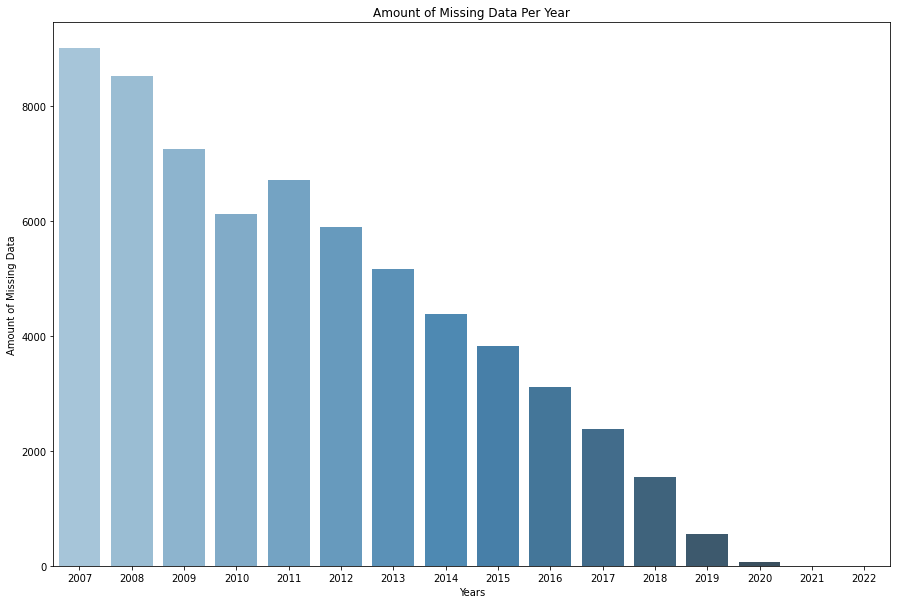

In [ ]:
#Let's make some plots to understand how the missing data might affect our backtests
#Let's see how the years change the the reliability of the backtest

def get_missing_occurances(true_missing_tickers_and_dates):
  all_dates = None
  for missing_dates in true_missing_tickers_and_dates.values():
    all_dates = pd.concat([all_dates, missing_dates])
  
  missing_occurances = pd.DataFrame(all_dates, columns=['Dates']).reset_index(drop=True)

  #Create a date range per year to bin
  start_date = dt.date(2007,1,1)
  end_date = dt.date.today() + relativedelta(years=1)
  date_range = pd.date_range(start_date, end_date, freq='YS') #YS or Y
  x_axis_labels = date_range[:-1].strftime('%Y')

  missing_occurances['Years'] = pd.cut(missing_occurances['Dates'],
                                      bins=date_range,
                                      labels=x_axis_labels)
  return missing_occurances, date_range
  
missing_occurances, date_range = get_missing_occurances(true_missing_tickers_and_dates)
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.countplot(data=missing_occurances,
                  x='Years',
                  palette='Blues_d',
                  ax=ax)
_ = ax.set(title="Amount of Missing Data Per Year",
           ylabel="Amount of Missing Data")

In [ ]:
#From above we see that the relability of the data greatly increases as the years go by
#Most likely because Yahoo Finance tends to remove historicals that went through m&a or went bankrupt
#This is important as you will want bad companies in the sp500 for your backtest to reduce Survivorship Bias
#Additianally, this does not include our completely missing_yf_tickers, let's add those to the graph as well

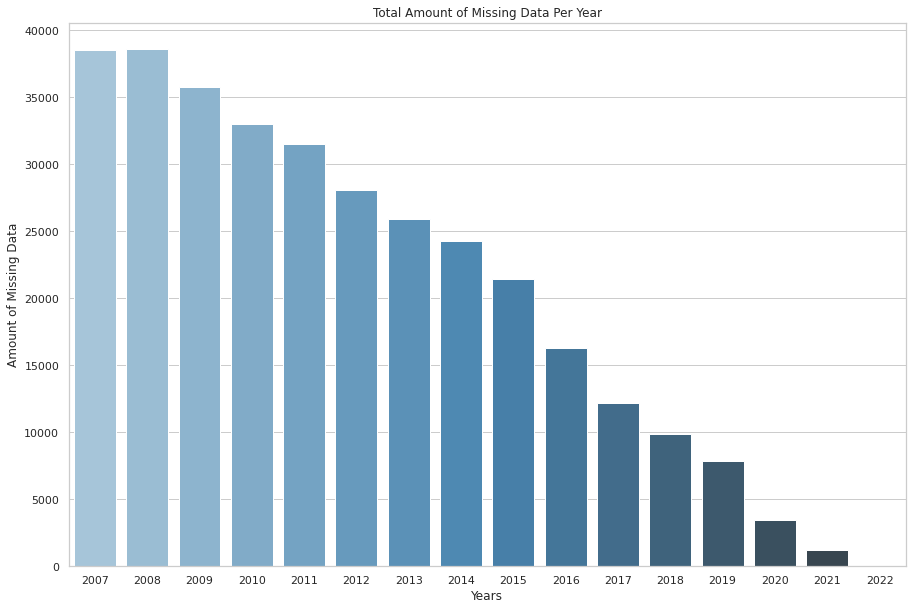

In [ ]:
#Using the modified function of what we used earlier in the tutorial avaliable in p3modules, we 
#Can find all the missing dates for the missing_yf_tickers and tally up all our missing data

from p3modules import p3Amodule

full_missing_tickers_and_dates = p3Amodule.find_all_missing_dates_when_not_in_sp500(missing_yf_tickers,
                                                                                  full_date_range,
                                                                                  sp500_changes)

full_missing_tickers_and_dates.update(true_missing_tickers_and_dates)
full_missing_data_per_year, _ = get_missing_occurances(full_missing_tickers_and_dates)

fig, ax = plt.subplots(figsize=(15,10))
ax = sns.countplot(data=full_missing_data_per_year,
                  x='Years',
                  palette='Blues_d',
                  ax=ax)
_ = ax.set(title="Total Amount of Missing Data Per Year",
          ylabel="Amount of Missing Data")

In [ ]:
#Printing out the values we see that there are over 38,000 missing historical dates for the years 2007 and 2008
#Translating this, there are 252 trading days a year so 38,000/252 we have about 151 out of 500 tickers missing for those years
#This is cruical because YF tends to delete data on bankrupt and merged companies, we will have to get those companies later

missing_per_year =  full_missing_data_per_year['Dates'].value_counts(bins=date_range)
print(missing_per_year.sort_index())

(2006-12-31 23:59:59.999999999, 2008-01-01]    38480
(2008-01-01, 2009-01-01]                       38616
(2009-01-01, 2010-01-01]                       35774
(2010-01-01, 2011-01-01]                       32996
(2011-01-01, 2012-01-01]                       31487
(2012-01-01, 2013-01-01]                       28080
(2013-01-01, 2014-01-01]                       25879
(2014-01-01, 2015-01-01]                       24246
(2015-01-01, 2016-01-01]                       21456
(2016-01-01, 2017-01-01]                       16250
(2017-01-01, 2018-01-01]                       12169
(2018-01-01, 2019-01-01]                        9863
(2019-01-01, 2020-01-01]                        7829
(2020-01-01, 2021-01-01]                        3468
(2021-01-01, 2022-01-01]                        1191
(2022-01-01, 2023-01-01]                           0
Name: Dates, dtype: int64


In [ ]:
#Continuing our EDA, let's see the misisng lengths of each ticker
all_missing_date_lengths = list()
for ticker, missing_dates in full_missing_tickers_and_dates.items():
  all_missing_date_lengths.append([ticker, len(missing_dates)])

all_missing_date_lengths = pd.DataFrame(all_missing_date_lengths, columns=['Ticker','Missing Lengths'])
all_missing_date_lengths = all_missing_date_lengths.sort_values('Missing Lengths',
                                                                ascending=True, 
                                                                ignore_index=True)
print(all_missing_date_lengths.head(20))
print(all_missing_date_lengths.describe())

   Ticker  Missing Lengths
0     NFX                1
1    EVHC                1
2    ESRX                1
3     TWX                1
4    ANDV                1
5     SNI                1
6     ROH                2
7    CMVT                3
8     CVG               14
9     EOP               15
10   APCC               18
11    HMA               25
12     PD               39
13    CMX               43
14    TSG               49
15      H               53
16  CMCSK               57
17    KMI               87
18   MEDI               91
19    MEL              109
       Missing Lengths
count       233.000000
mean       1406.798283
std        1051.652369
min           1.000000
25%         474.000000
50%        1258.000000
75%        2192.000000
max        3757.000000


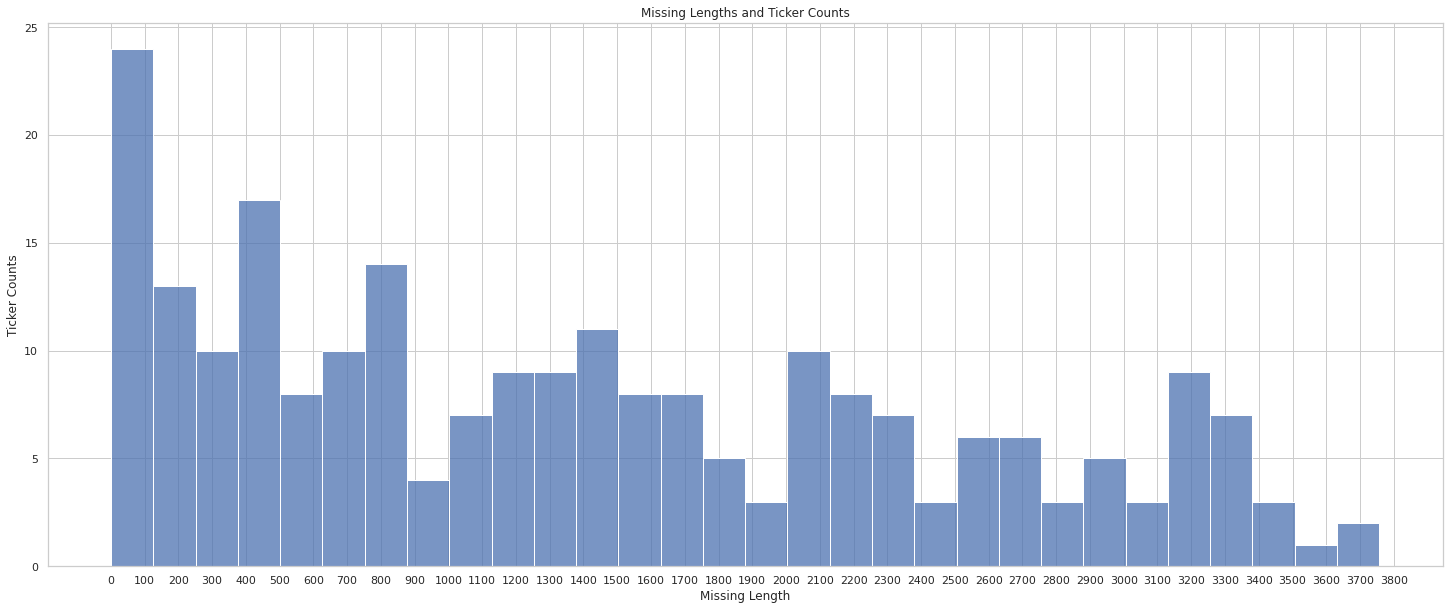

In [ ]:
#Plotting them and seeing the head above we see that there are over 20 tickers with less than 109 dates missing
#Could inspect these tickers and if unavaliable from other databases, we could linearly interpolate them if they are within a tolerance of known data
fig, ax = plt.subplots(figsize=(25,10))
sns.set_theme(style="whitegrid")          
ax = sns.histplot(x=all_missing_date_lengths['Missing Length'], bins=30, ax=ax)
_ = ax.set(xticks=range(0, 3900, 100), 
          title="Missing Lengths and Ticker Counts",
          ylabel="Ticker Counts")

In [ ]:
#This concludes the end of the this quick EDA
#Hopefully it gave ways on how you to handle your missing data and the large holes of the YF dataset
#From here there are a multiple ways to handle the missing data
#But I recommend looking for paid for databases to source your data from, and not just YF
#Additionally here are three common problems among our dataset and even paid sources will have:
  #On the sp500_changes, some tickers are misnamed, for example '$SHLD', which is Sears has the ticker '$SHLDQ'
  #YF has many missing historicals and even the paid databases are missing information, you will have to do manual research for many
  #Even historical OHLC data can be wrong
    #You can create a data pipeline to check for errors or average out your OHLCs from other data sources to approximate the actual result

In [ ]:
#Finally let's dump our full_missing_tickers_and_dates list, so we can pick them up from a REST API later in Part 3B Tutorial
#We will have to do some formatting on it to save it as a json

def format_tickers_and_missing_dates_for_json(full_missing_tickers_and_dates):
  formatted_full_missing_tickers_and_dates = dict()
  for ticker, missing_dates in full_missing_tickers_and_dates.items():
    #Need timestamps and lists to save file as jsons
    formatted_full_missing_tickers_and_dates[ticker] = missing_dates.apply(lambda x: x.timestamp()).values.tolist() 
  return  formatted_full_missing_tickers_and_dates

save_filepath = '/p3Aoutputs/full_missing_tickers_and_dates.json'
formatted_full_missing_tickers_and_dates = format_tickers_and_missing_dates_for_json(full_missing_tickers_and_dates)

with open(save_filepath, 'w', encoding='utf-8') as f:
  json.dump(formatted_full_missing_tickers_and_dates, f, ensure_ascii=False, indent=4)

## Reference: Cutting the Extra Date in 'GS' and 'DIA'

In [ ]:
#Let's take a look at GS and DIA
display(historicals['GS'])
display(historicals['DIA'])

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-19,NaN,NaN,NaN,NaN,NaN
2007-01-22,171.830744,173.589023,170.617868,173.361099,4980700.0
2007-01-23,173.239028,173.727431,171.472601,173.092499,6293400.0
2007-01-24,173.800764,179.222121,173.410040,179.165146,6386800.0
2007-01-25,178.945284,179.498809,172.986676,173.442535,7853800.0
...,...,...,...,...,...
2022-01-12,403.239990,404.119995,388.559998,390.309998,4158000.0
2022-01-13,394.049988,396.869995,389.750000,390.799988,2497800.0
2022-01-14,382.130005,384.390015,375.000000,380.940002,4682000.0


,Open,High,Low,Close,Volume
Date,,,,,
2007-01-19,NaN,NaN,NaN,NaN,NaN
2007-01-22,88.966654,88.987923,88.186738,88.449074,10233200.0
2007-01-23,88.420679,88.916990,88.328510,88.860268,6596600.0
2007-01-24,88.987882,89.420379,88.895707,89.384926,10118500.0
2007-01-25,89.356522,89.420335,88.477351,88.604973,8768800.0
...,...,...,...,...,...
2022-01-12,363.730011,364.559998,361.670013,362.950012,4493200.0
2022-01-13,364.209991,365.130005,360.450012,361.200012,6418100.0
2022-01-14,358.209991,359.799988,356.399994,359.140015,8573900.0


In [ ]:
#We can see that they just have a top Nan row, let's use drop.na() on them in order for them to fit our chosen standard length
historicals['GS'] = historicals['GS'].dropna()
historicals['DIA'] = historicals['DIA'].dropna()

In [ ]:
#Double check it worked
print('GS Check {}'.format(full_date_range.difference(historicals['GS'].index)))
print('DIA Check {}'.format(full_date_range.difference(historicals['DIA'].index)))
display(historicals['GS'])

GS Check DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)
DIA Check DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)


,Open,High,Low,Close,Volume
Date,,,,,
2007-01-22,171.830744,173.589023,170.617868,173.361099,4980700.0
2007-01-23,173.239028,173.727431,171.472601,173.092499,6293400.0
2007-01-24,173.800764,179.222121,173.410040,179.165146,6386800.0
2007-01-25,178.945284,179.498809,172.986676,173.442535,7853800.0
2007-01-26,174.655474,174.932237,171.431974,173.792618,7458200.0
...,...,...,...,...,...
2022-01-12,403.239990,404.119995,388.559998,390.309998,4158000.0
2022-01-13,394.049988,396.869995,389.750000,390.799988,2497800.0
2022-01-14,382.130005,384.390015,375.000000,380.940002,4682000.0


In [ ]:
#Since there was no difference in the dates index, then GS and DIA are now the standard size of our Yahoo Finance Data
#Because it is a different array shape you will have to delete your current hdf5 data for GS and DIA and insert their updated data